In [1]:
%matplotlib inline
%load_ext autoreload
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import logging
from collections import Counter
from dfply import *
from gp.gp import *
from gp.kernels import SquaredExponentialKernel
from gp.algs import pick_idxs_const_gp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
df = pd.read_csv("results/fold_11/test_df.csv")

In [4]:
mu = np.load("./results/fold_11/mu.npy").item()
std = np.load("./results/fold_11/std.npy").item()

In [5]:
df["pred"] = (df["pred"] - mu) / std
df["true"] = (df["true"] - mu) / std

In [6]:
final_layer = np.load("results/fold_11/final_layer.npy")

In [7]:
final_layer_weight = np.load("results/fold_11/final_layer_weight.npy")[0]
final_layer_bias = np.load("results/fold_11/final_layer_bias.npy")

In [8]:
df = df >> select(X.true, X.pred, X.lat, X.lng, X.taluk_idx, X.district_idx)

In [11]:
def calc_r2_score(df, preds, level="village"):
    df["tmp_pred"] = preds
    if level == "village":
        return r2_score(df["true"], df.tmp_pred)
    elif level == "taluk":
        tmp = df >> group_by(X.taluk_idx) >> summarise(true = X.true.mean(), pred = X.tmp_pred.mean())
        return r2_score(tmp["true"], tmp["pred"])
    elif level == "district":
        tmp = df >> group_by(X.district_idx) >> summarise(true = X.true.mean(), pred = X.tmp_pred.mean())
        return r2_score(tmp["true"], tmp["pred"])
    else:
        raise ValueError

In [12]:
calc_r2_score(df, df["pred"])

0.19538619918109068

In [13]:
calc_r2_score(df, df["pred"], "taluk")

0.4489055853955016

In [14]:
calc_r2_score(df, df["pred"], "district")

0.5821540807220236

In [15]:
def plot_map(df):
    plt.hexbin(df["lng"], df["lat"], df["true"], vmin=-3, vmax = 3)

Text(0.5, 1.0, 'CNN-Predicted')

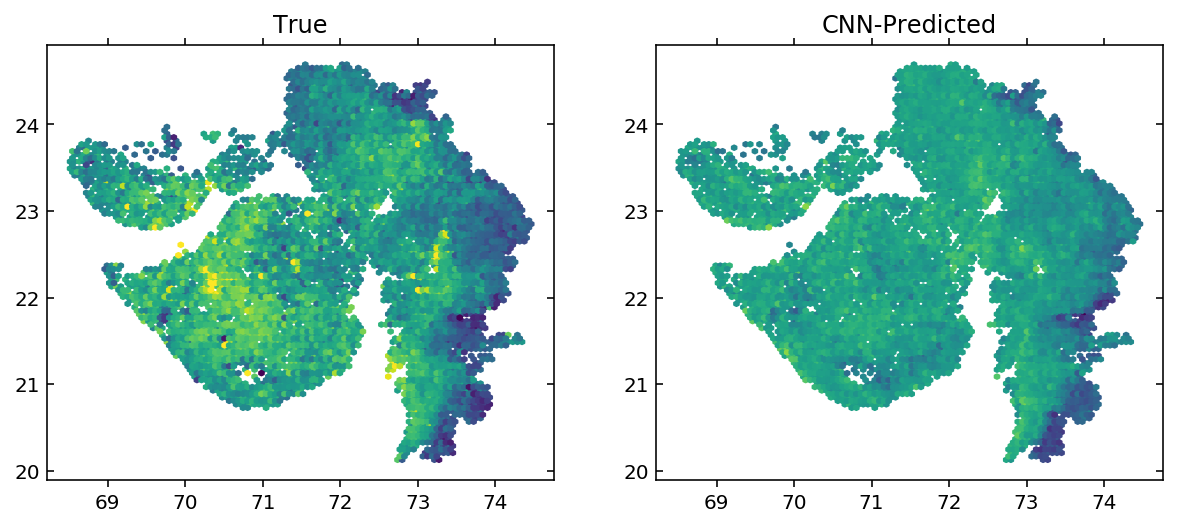

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], df["true"], vmin=-3, vmax = 3)
plt.title("True")
plt.subplot(1,2,2)
plt.hexbin(df["lng"], df["lat"], df["pred"], vmin=-3, vmax=3)
plt.title("CNN-Predicted")

In [17]:
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, test_idxs = idxs[:len(idxs) // 3 * 2], idxs[len(idxs) // 3 * 2:]

In [18]:
final_layer = np.c_[final_layer, np.ones(len(final_layer))]

In [19]:
df_train = df >> row_slice(train_idxs)
df_test = df >> row_slice(test_idxs)

In [20]:
h_train = final_layer[train_idxs]
h_test = final_layer[test_idxs]

In [21]:
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (11826, 7)
Test: (5913, 7)


Try sampling 500 RANDOM on-the-ground villages.

In [22]:
B = 1e-5 * np.eye(1001)

In [23]:
kernel = SquaredExponentialKernel(0.1, 0.05)
gp = StochasticMeanGP(np.r_[final_layer_weight, final_layer_bias], B, kernel, 0.01)

In [24]:
idxs = np.random.choice(np.arange(len(df_train)), 500)

In [25]:
gp.fit(df_train[["lat","lng"]].values[idxs,:],  
       df_train["true"].values[idxs],
       h_train[idxs])

-8.933790288117216

In [26]:
mean, var = gp.predict(df_test[["lat", "lng"]].values, h_test)

In [27]:
calc_r2_score(df_test, mean, "taluk")

0.5773143804294123

In [28]:
calc_r2_score(df_test, df_test["pred"], "taluk")

0.40792352582662184

In [31]:
posterior_mean, posterior_var = gp.get_beta()

Try sampling 500 PRIOR VARIANCE on-the-ground villages.

In [32]:
prior_cov = kernel(df_train[["lat", "lng"]].values, df_train[["lat", "lng"]].values) + h_train @ B @ h_train.T

In [33]:
prior_variances = np.diag(prior_cov)

In [34]:
idxs = np.random.choice(np.arange(len(df_train)), 500, p=prior_variances / np.sum(prior_variances))

NameError: name 'top_pts' is not defined

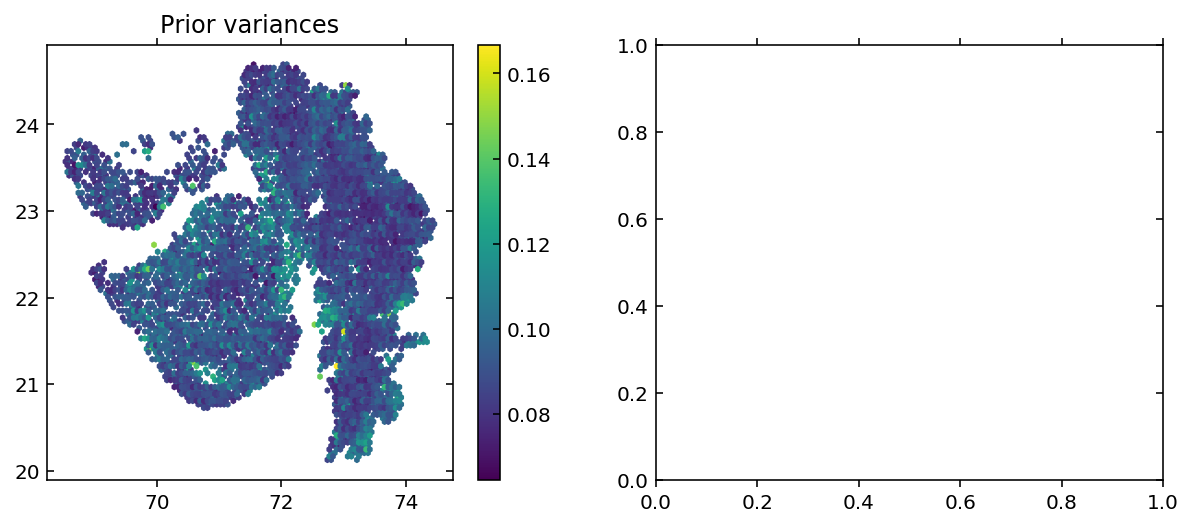

In [35]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hexbin(df_train["lng"], df_train["lat"], prior_variances)
plt.colorbar()
plt.title("Prior variances")
plt.subplot(1, 2, 2)
plt.scatter(df_train["lng"][top_pts], df_train["lat"][top_pts], marker=".")

In [ ]:
gp.fit(df_train[["lat","lng"]].values[idxs,:],  
       df_train["true"].values[idxs],
       h_train[idxs])

In [ ]:
mean, var = gp.predict(df_test[["lat", "lng"]].values, h_test)

In [ ]:
calc_r2_score(df_test, mean, "taluk")

In [ ]:
calc_r2_score(df_test, df_test["pred"], "taluk")

Try sampling 500 SEQUENTIAL on-the-ground villages by picking out maximum variance in GP step by step.

In [194]:
idxs = np.array([np.argmax(prior_variances)])

In [195]:
all_idxs = np.random.choice(np.arange(len(train_idxs)), 3000) # Todo: sample proportional to prior variance

In [ ]:
for _ in tqdm(range(499)):
    gp.fit(df_train[["lat","lng"]].values[idxs,:],  
       df_train["true"].values[idxs],
       h_train[idxs])
    remaining_idxs = np.array(list(set(all_idxs) - set(idxs)))
    mean, var = gp.predict(df_train[["lat", "lng"]].values[remaining_idxs,:], h_train[remaining_idxs,:])
    var[np.isnan(var)] = 0
    idxs = np.append(idxs, remaining_idxs[np.argmax(np.diag(var))])

In [197]:
gp.fit(df_train[["lat","lng"]].values[idxs,:],  
       df_train["true"].values[idxs],
       h_train[idxs])

-6.451557404676668

In [198]:
mean, var = gp.predict(df_test[["lat", "lng"]].values, h_test)

In [202]:
calc_r2_score(df_test, mean, "taluk")

0.718703013555718

Try sampling 500 on-the-ground villages by sampling from the taluk with highest fraction of villages unexplored.

In [269]:
total_counts = Counter(df_train["taluk_idx"])

In [270]:
all_idxs = np.arange(len(train_idxs))

In [271]:
idxs = np.array([train_idxs[0]])

In [272]:
for _ in tqdm(range(499)):
    remaining_idxs = np.array(list(set(all_idxs) - set(idxs)))
    remaining_counts = total_counts - Counter(df_train.iloc[idxs]["taluk_idx"])
    taluks = np.zeros(max(total_counts.keys()) + 1)
    for k, v in remaining_counts.items():
        taluks[k] = v / total_counts[k]
    taluk_chosen = np.argmax(taluks)
    mask = df_train.iloc[remaining_idxs]["taluk_idx"] == taluk_chosen
    chosen_idx = np.random.choice(remaining_idxs, p=mask * remaining_idxs / sum(mask * remaining_idxs))
    idxs = np.append(idxs, chosen_idx)


100%|██████████| 499/499 [00:04<00:00, 112.28it/s]

In [274]:
gp.fit(df_train[["lat","lng"]].values[idxs,:],  
       df_train["true"].values[idxs],
       h_train[idxs])

-10.924214711380312

In [275]:
mean, var = gp.predict(df_test[["lat", "lng"]].values, h_test)

In [276]:
calc_r2_score(df_test, mean, "taluk")

0.5198121182108855

Miscellaneous code below.

In [61]:
from gp.utils import cal_error

In [62]:
calib, pred, obs = cal_error(df_test["true"], mean, var, 10)

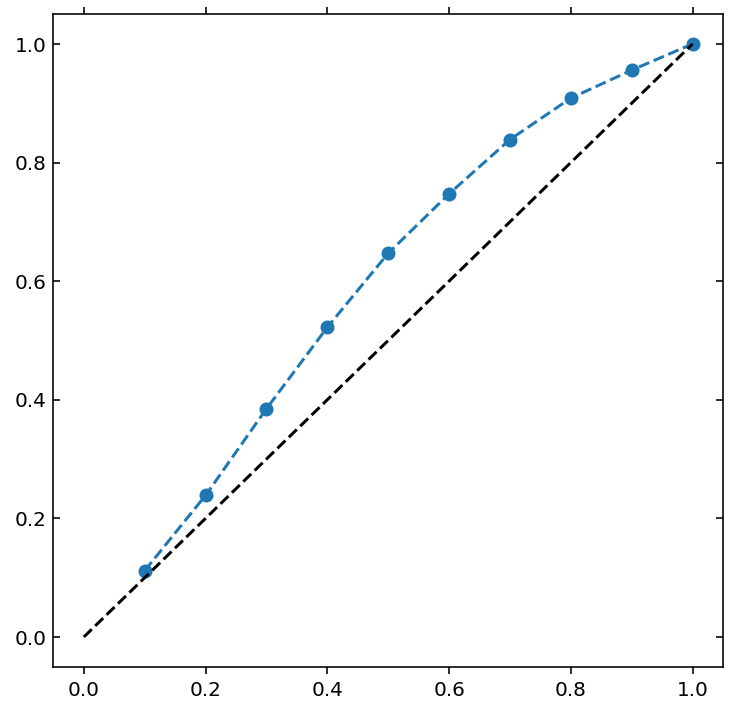

In [67]:
plt.figure(figsize=(6, 6))
plt.plot(pred, obs, "--o")
plt.plot([0, 1], [0, 1], "--", color="black")